# Deep riccy project


## Introduction 

This project focuses on addressing the challenge of **visual grounding**, which involves establishing a connection between language and visual information. Visual grounding is essential for bridging the gap between symbolic language representation and understanding the visual world.

This project builds on the [CLIP](https://arxiv.org/abs/2103.00020) paradigm, modifying its approach to enhance performance.

Three distinct approaches were explored and combined to achieve optimal results:

*  The first approach utilizes natural language processing (NLP) techniques to identify the subject of a sentence and filter out unwanted predictions from [YOLO (You Only Look Once)](https://arxiv.org/pdf/1506.02640.pdf) bounding boxes. This approach, in conjunction with the baseline, forms the initial strategy. First, we filter out the images that do not contain the subject we extracted. Then, we compute the similarities between the remaining images and the caption, and finally we select the result with the highest similarity as the final outcome. 


* The second approach starts from the CLIP paradigm and replaces the computation of similarity between texts and images, with texts to text. In fact we fine-tuned on RefCOCOg an image captioner model. This image captioner will create a caption for each of the extracted YOLO bounding boxes, but before generating them we will apply our NLP in order to remove the undesired ones. Then we will compute the cosine similarity between the generated captions and the one coming from the dataset, and finally take the best one.

* The third approach can be viewed as a "reverse process" of the second one. In fact for each caption we generate synthetic images that should represent at best the desired target. Once we obtained the images, we filter out the bounding boxes that are not relevant (as we did in the other approaches), compute the similarity between the bounding boxes and the generated images, and then we select them using a selection process that takes as prediction the "winner" of most comparisons.

* Finally we combined this approaches all together with the baseline.

By exploring these approaches and their combinations, this project aims to advance the field of visual grounding and enable effective language-to-visual connections for improved understanding and interpretation of visual data.


## Environment creation


This section is dedicated to the creation of the environment. In order to run this notebook this section will guide you through the creation of the environment by installing the dependencies necessary for the execution of the code. Another important aspect for the code to run is to have set the correct paths for the dataset and the weights of the models.
In the case that the environment is already set up, you can skip this section and go directly to the next one.
If the dataset is not yet unpacked you need to run the commented code in the next cell, otherwise you can skip it. It is commented because it is not necessary to run it every time you run the notebook, but only the first time and it takes time.
</br>
The dependecies that we install are the following:
- diffusers==0.11.1
- transformers 
- scipy 
- ftfy 
- accelerate
- stanza
- all requirements for yolo
- all requirements for clip
- torchmetrics
- datasets
- torchvision
- datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#this line is necessary if you need to unpack the dataset
#! tar -zxvf /content/drive/MyDrive/refcocog.tar.gz

! pip3 install ftfy regex tqdm --quiet
! pip3 install diffusers==0.11.1 --quiet
! pip3 install transformers scipy ftfy accelerate --quiet
! pip3 install stanza --quiet
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  --quiet
! pip install git+https://github.com/openai/CLIP.git --quiet
! pip install torchmetrics --quiet
! pip install torchvision --quiet
! pip install datasets --quiet



In [ ]:
#this values needs to change based on where the data is stored

local_path = 'refcocog/images/'                #path to the images
local_annotations = 'refcocog/annotations/'     #path to the annotations
image_captioner_model_path = 'Image_Captioning_VIT_Roberta_final_4' #path to the model weight for the image captioning
caption_json = 'image_captioning_validation.json'   #path to the json file for the captions

In [ ]:
import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import clip
import numpy as np
import torchvision
from torchvision import ops
import stanza
from tqdm import tqdm

from transformers import ViTFeatureExtractor, VisionEncoderDecoderModel
from transformers import RobertaTokenizerFast

#ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## Utilities


This section is dedicated to technical function to clean the code and make it more readable, by not repeting some of the tasks.

In [4]:
#this function removes closing and opening tags from the captions
def clear_caption(caption):
    caption = caption.replace('<s>', '')
    caption = caption.replace('</s>', '')
    return caption

In [5]:
#function that given a yolo output returns the cropped image based on the index witch reppresents the jolo bounding box
def crop_yolo(yolo_output, img, index):
    #conversion to numpy and rounding to get the coordinates
    x1 = yolo_output.xyxy[0][index][0].cpu().numpy()
    x1 = np.rint(x1)
    y1 = yolo_output.xyxy[0][index][1].cpu().numpy()
    y1 = np.rint(y1)
    x2 = yolo_output.xyxy[0][index][2].cpu().numpy()
    x2 = np.rint(x2)
    y2 = yolo_output.xyxy[0][index][3].cpu().numpy()
    y2 = np.rint(y2)

    cropped_img = img.crop((x1, y1, x2, y2))
    
    return cropped_img

In [10]:
# remove the id in the image name string
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append

    return string

In [11]:
# convert yolo format bbox into standard type
def convert_bbox(bbox, img):
    x1, y1, width, height = bbox
    x2, y2 = x1 + width, y1 + height

    # Verify coordinates
    if x1 < 0 or y1 < 0 or x2 > img.width or y2 > img.height:
        print("Bounding box fuori dai limiti dell'immagine!")
    else:
        return x1, y1, x2, y2

In [12]:
# yolo bbox include class and precision, drop them
def convert_yolo_bbox(bbox):
    return bbox[:4]

In [13]:
#loads from a json file and returns a dataframe
def load_dataframe(path):
    #load json
    with open(path) as json_file:
        data = json.load(json_file)
        #create dataframe   
        df = pd.DataFrame(data)
    
    return df

In [ ]:
# given an image pad the image to fit the dimension of clip and fill the padding with the median color of the image
def padd_image(img):
    # find the average color of the image
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    old_image_width, old_image_height = img.size

    # create new image of desired size and color for padding
    if (old_image_height > 224 or old_image_width > 224):
        if (old_image_height > old_image_width):
            new_image_width = old_image_height
            new_image_height = old_image_height

        else:
            new_image_width = old_image_width
            new_image_height = old_image_width

        color = avg_color

        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)

        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    else:
        new_image_width = 224
        new_image_height = 224

        color = avg_color
        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)
        
        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    img = Image.fromarray(result)
    img = img.resize((224, 224))
    return img

In [14]:
# test model on a number N of images and print metrics each tenth of the images
def test_on_n_images(model, dataset, N):
    model.reset_metrics()

    for i in range(0, N):
        input = dataset[i]
        image_path = split_string(input["file_name"])
        sentence = input["sentences"]["raw"]
        gt = input["bbox"]
        original_img = Image.open(local_path + image_path).convert("RGB")
        # print img dimensions and box coordinates
        bbox, img = model.evaluate(image_path, sentence, gt, original_img)

        if i % (N/10) == 0:
            print("Iteration: ", i)
            print(model.get_metrics())

In [15]:
# function that validates a model on a given dataframe
def validate(model, dataframe):
    model.reset_metrics()
    for i in tqdm(range(0, len(dataframe))):
        input = dataframe.iloc[i]
        image_path = split_string(input["file_name"])
        sentence = input["sentences"]["raw"]
        gt = input["bbox"]
        original_img = Image.open(local_path + image_path).convert("RGB")
        model.evaluate(image_path, sentence, gt, original_img, i)

    model.save_metrics()
    print(model.get_metrics())

In [16]:
# function that tests a model on a given image
def test_on_one_image(model, dataframe, index):
    model.reset_metrics()

    input = dataframe.iloc[index]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]

    original_img = Image.open(local_path + image_path).convert("RGB")

    bbox, _ =model.evaluate(image_path, sentence, gt, original_img, index)
    bbox = bbox.cpu().numpy()
    #show image with bbox and caption and gound truth
    %matplotlib inline
    plt.imshow(original_img)

    x1, y1, width, height = gt
    #draw bounding boxes on image
    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='red', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='blue', linewidth=2))
    
    print(sentence)
    plt.show()

    print(model.get_metrics())

TODO non so se questo vogliamo mantenerlo ma bisogna fixarlo

In [17]:
import random
#a function that given a list of models tests on a specific image and shows the results in a plot grid
def compare_models(models, dataframe, index):
    
    input = dataframe.iloc[index]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]

    bboxes = []

    original_img = Image.open(local_path + image_path).convert("RGB")
    for model in models:
        bbox, _ =model.evaluate(image_path, sentence, gt, original_img)
        bbox = bbox.cpu().numpy()
        bboxes.append(bbox)
    
    #add all the bboxes to the plot and show image with label and gound truth
    for i in range(0, len(bboxes)):
        #rotating colors with random
        bbox= bboxes[i]
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2))
        #add lable for the model
        plt.text(bbox[0], bbox[1], models[i].name, fontsize=12, color=color)

## Metrics


In [18]:
# definition of recall metric
class Recall:
    def __init__(self):
        self.true_positives = 0
        self.false_negatives = 0

    def update(self, correct):
        if correct:
            self.true_positives += 1
        else:
            self.false_negatives += 1

    def compute(self):
        return self.true_positives / (self.true_positives + self.false_negatives)

    def reset(self):
        self.true_positives = 0
        self.false_negatives = 0

### Intersection Over Union
Intersection over Union (IoU) is used to evaluate the performance of object detection by comparing the ground truth bounding box to the preddicted bounding box.
<img src='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=1&strip=1&webp=1' style="width: 30%">

Examining this equation you can see that Intersection over Union is simply a ratio.
In the numerator we compute the area of overlap between the predicted bounding box and the ground-truth bounding box.
The denominator is the area of union, or more simply, the area encompassed by both the predicted bounding box and the ground-truth bounding box.
Dividing the area of overlap by the area of union yields our final score — the Intersection over Union.

### Recall
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive. For our model we consider classified as positive if the IOU for that prediction is over 0.5
$$ Recall = {True Positive \over True Positive + False Negative} $$


### Euclidean Distance


Euclidean Distance is a measure of distance and it works on the principle of Pythagoras theorem and signifies the shortest distance between two points.
$$ Euclidean Distance = \sqrt{(x_2-x_1)^2+(y_2-y_1)^2} $$

For points in more than two dimensions: 

$$ Euclidean Distance =  \sqrt{ \sum_{i=1}^n  (p_i-q_i)^2} $$

Euclidean distance is used in many machine learning algorithms as a default distance metric to measure the similarity between two recorded observations.  Users mostly opt for it to calculate the distance between two rows of data that consists of numerical values.
In our specific case it is used to calculate the distance between two images (the groundtruth and our prediction)

### Cosine Similarity

Cosine similarity is a metric used to measure the similarity of two vectors. Specifically, it measures the similarity in the direction or orientation of the vectors ignoring differences in their magnitude or scale. Both vectors need to be part of the same inner product space, meaning they must produce a scalar through inner product multiplication. The similarity of two vectors is measured by the cosine of the angle between them.

$$ Similarity(A,B) =cos(\theta) ={A * B  \over ||A||*||B||} $$

where $$ \theta $$  is the angle between the vectors <br>
 A*B   is dot product between A and B and calculated as: 
$$ A * B = A^T B = \sum_{i=1}^n A_i B_i  = A_1 B_1 + A_2 B_2 + ... + A_n B_n $$
and ||A|| represents the L2 norm of 

In [19]:
class Metrics:
    def __init__(self, model, name):
        self.name = name
        self.treshold = 0.5
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        ])
        # initialize torch tensor
        self.iou = torch.tensor([]).cuda()
        self.recall = Recall()
        self.model = model
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

    #method that updates the metrics
    def update(self, predicted_bbox, target_bbox, predicted_image, target_image):
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)

        with torch.no_grad():
            # Preprocess the predicted image and compute the predicted embedding
            predicted_image = padd_image(predicted_image)
            image_tensor = self.transform(predicted_image)
            image_tensor = image_tensor.unsqueeze(0).cuda()
            predicted_embedding = self.model.encode_image(image_tensor)

            # Preprocess the target image and compute the target embedding
            target_image = padd_image(target_image)
            target_image_tensor = self.transform(target_image)
            target_image_tensor = target_image_tensor.unsqueeze(0).cuda()
            target_embedding = self.model.encode_image(target_image_tensor)

        # compute cosine similarity and euclidean distance
        similarity = torch.nn.functional.cosine_similarity(predicted_embedding, target_embedding)
        distance = torch.nn.functional.pairwise_distance(predicted_embedding, target_embedding)

        # convert bboxes into torch tensors
        predicted_bbox = torch.tensor(predicted_bbox)
        target_bbox = torch.tensor(target_bbox)

        predicted_bbox = convert_yolo_bbox(predicted_bbox)

        # compute iou for the specific image
        actual_iou = ops.box_iou(predicted_bbox.unsqueeze(0).cuda(), target_bbox.unsqueeze(0).cuda())
        self.iou = torch.cat((self.iou, actual_iou), 0)

        # update recall based on iou treshold
        if actual_iou > self.treshold:
            self.recall.update(True)
        else:
            self.recall.update(False)

        # update cosine similarity and euclidean distance
        self.cosine_similarity = torch.cat((self.cosine_similarity, similarity), 0)
        self.euclidean_distance = torch.cat((self.euclidean_distance, distance), 0)

    def to_string(self):
        #compute metrics
        mean_iou = torch.mean(self.iou)
        recall_at_05_iou = self.recall.compute()
        mean_cosine_similarity = torch.mean(self.cosine_similarity)
        mean_euclidean_distance = torch.mean(self.euclidean_distance)

        return f"Mean IoU: {mean_iou:.4f}, Recall@0.5 IoU: {recall_at_05_iou:.4f}, Mean Cosine Similarity: {mean_cosine_similarity:.4f}, Mean Euclidean Distance: {mean_euclidean_distance:.4f}"

    #method that saves the metrics in csv files
    def  save(self):
        iou = self.iou.cpu().numpy()
        cosine_similarity = self.cosine_similarity.cpu().numpy()
        euclidean_distance = self.euclidean_distance.cpu().numpy()

        np.savetxt(self.name+"_iou.csv", iou, delimiter=",")
        np.savetxt(self.name+"_cosine_similarity.csv", cosine_similarity, delimiter=",")
        np.savetxt(self.name+"_euclidean_distance.csv", euclidean_distance, delimiter=",")

    def reset(self):
        self.iou = torch.tensor([]).cuda()
        self.recall.reset()
        self.cosine_similarity = torch.tensor([]).cuda()
        self.euclidean_distance = torch.tensor([]).cuda()

## Dataset


In order to use the given dataset called RefCOCOg consisting of approximately 25,799 images with multiple captions for each image. This dataset does not have an official dataset class already existing so we needed to adapt and create a class that would allow us to use the dataset in the best way possible. The class is the following and allows to load all the data from multiple file, to link the images to the captions and to the bounding boxes using json and .p files. 
The class we created rely on dataframes witch are a very useful tool in this situations, infact they allow us to easily manipulate the data and to link the images to the captionsby few commands and without the need to iterate over the data. In order for us to proprely use the data we consider the caption as main element, since for one image we have multiple captions.

In [20]:
# dataset class definition
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        # load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)

        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        # separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sentences')
        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        # merge the dataframes
        self.dataset = pd.merge(
            self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        
        # drop useless columns for cleaner and smaller dataset
        self.dataset = self.dataset.drop(columns=['segmentation', 'id', 'category_id_y', 'ref_id', 'index_x',
                                         'iscrowd', 'image_id_y', 'image_id_x', 'category_id_x', 'ann_id', 'sent_ids', 'index_y', 'area'])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
        return self.ann_frame.iloc[idx]

    def get_imgframe(self, idx):
        return self.img_frame.iloc[idx]

    def get_validation(self):
        return self.dataset[self.dataset['split'] == 'val']

    def get_test(self):
        return self.dataset[self.dataset['split'] == 'test']

    def get_train(self):
        return self.dataset[self.dataset['split'] == 'train']

In [21]:
# dataset loading test and dimension check
dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")
print(len(dataset))

In [22]:
# to test prints the dataframe that composes the dataset
dataset.dataset

## Base model

### Model definition

The baseline model sets a base score to the task in the dataset as suggested in the problem statement.
It has a fairly simple pipeline using YOLO model and CLIP, with default parameters value. </br>
Pipeline is defined as follows:
- YOLO model is used to detect objects in the image.
- The detected objects are then passed to the CLIP model to get the similarity scoress between the image and the caption.
- The cropped image with the highest similarity score is chosen as prediction result.

<img src= "https://drive.google.com/uc?id=1tIB5jgT_cEzim-a_WLO77HKRxhidOZBp" style="width: 80%;">

In [24]:
# class that defines the baseline model
class VisualGrounding_baseline(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_baseline, self).__init__()
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "baseline"

        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        
    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        #pass yolo
        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")
        text = clip.tokenize([sentence]).cuda()
        text_features = self.clip.encode_text(text).float()

        for i in range(len(yolo_output.xyxy[0])):
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img = self.preprocess(img_cropped).cuda().unsqueeze(0)

            #calculate with clip the embedding of the image
            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            #find max similarity
            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]
                
        #manage the case in which no bbox is found
        if max_image is None:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()

    def save_metrics(self):
        self.metrics.save()

## STANZA NLP analysis 

To discriminate our final predictions we use some Natural Language Processing techniques in order to find the subject of the given caption. 
What we decided to use is the [Dependency graph](https://www.analyticsvidhya.com/blog/2021/12/dependency-parsing-in-natural-language-processing-with-examples/) technique. This is useful because it represents the dependencies between the various tokens inside of a sentence. 
In fact in each sentence we can define the so called **root**, which is the token on which all other tokens in the sentence depend. This can generate two possible scenarios: 
- **The root is a noun**: this is the best case for our task since we can identify that name as the subject of the caption.
- **The root is a verb**:  This case creates what is called a **"verbal phrase"**, which is a sentence in which the root is a verb. Removing it from the sentence would make it lose meaning. When we have such type of sentence, there is high chance of having inside of the dependencies, the so called "NSUBJ" or  [Nominal Subject](https://universaldependencies.org/en/dep/nsubj.html) (both active and passive). If it is present than this is the subject of our sentence. 
Otherwise if it is not present, once we have found the root of the sentence as a verb, we go back from the verb to the beginning of the sentence and we select as root of the sentence the first noun that we find.  <br>
In the image below is showed an example of dependency graph.

<img src='https://editor.analyticsvidhya.com/uploads/29920Screenshot%20(127).png' style="width: 70% ">
</br>
In the dependency graph, the root can be indentifyed as it is the only one word that has no entering arrows.

### Install STANZA dependency graph model

In [ ]:
#import STANZA NLP model for english language
stanza.download('en',model_dir='/models/english',package='partut')
nlp = stanza.Pipeline(lang='en')

### Preprocess not well-formed sentences 


We noticed that there was a problem with the so called "**not well-formed**" sentences (*In natural language processing, a not well-formed sentence refers to a sentence that does not conform to the rules and conventions of the language, making it difficult or impossible to be accurately processed and understood by a computer program or a human reader*), this was creating the effect of not being able to find the correct root of the sentence. 
For example one of the cases we encountered was the sentence: "*boy holding two bears*".
Analyzing it with [corenlp](https://corenlp.run/) gave us the following result: <br>

![picture](https://drive.google.com/uc?id=1KrY63kV1KwWWsjyyPnIlsOW1rUtU0KXM) 

This is an example of a "not well-formed" sentence, in fact although the root of the sentence is the verb "holding", when we apply the NLP parsing we cannot retrieve the noun "boy" as the subject of the sentence since it is recognised as an [INTJ](https://universaldependencies.org/u/pos/INTJ.html).

In order to solve this problem we noticed that adding a [determiner](https://universaldependencies.org/u/pos/DET.html) at the beginning of the sentence allows us to avoid having such problems. Through all the possible determiners, we chose "*the*" as it does not change the meaning of the sentence and it is the most general one. 

After this is applied, we obtain the following dependecy parsing in which the word "boy" is parsed as a [NOUN](https://universaldependencies.org/u/pos/NOUN.html) 

![picture](https://drive.google.com/uc?id=1Rt4nU5kXKSn-pq6nRkaCAcyp__m7Z1cd) <br>


### STANZA sentence preprocess


Before analyzing a sentence, we have a preliminary step in which we exclude certain errors in our subject prediction. One observation we made is that the conjunction phrase "*that is*" often introduces positional information about the dataset, which can conflict with the subject recognition task. Consequently, we have chosen to remove such phrases. Another issue arises with specific quantifiers, such as "*the part of*","*the side of*", "*the bunch of*", and "*the piece of*" . The problem here is that the word between "*the*" and "*of*" is mistakenly recognized as the subject of the sentence, resulting in an error. By eliminating these parts of the sentence, along with anything that precedes them, we can avoid this error and correctly identify the intended subject. Consider the sentence: "*The end of a table, with a pink tablecloth, at which eight people are sitting.*", this serves as a perfect example. 
Without applying pre-processing, the extracted subject would be "*end*" since it is a noun and the root of our sentence. However, our desired subject and root is "*table*".

![picture](https://drive.google.com/uc?id=18NsJQmaljnDhXOv4ZeO-NDeJVTsY0Lyr) <br>

 By removing everything preceding the specific quantifier "*the end of*", we can successfully identify and recognize "*table**" the intended subject.


![picture](https://drive.google.com/uc?id=1hiEErzQjWBh7WJCWCaDXLc0Xgzp0xOR1) <br>



#### CAMBIA FOTO

In [ ]:
# to remove all the specific quantifiers
def remove_of(sentence):
 if "the side of" in sentence:
    index=sentence.find("the side of")
    sentence=sentence[index+11:]
    return sentence
 if "the handle of" in sentence:
    index=sentence.find("the handle of")
    sentence=sentence[index+13:]
 if "the bunch of" in sentence:
    index=sentence.find("the bunch of")
    sentence=sentence[index+12:]
    return sentence   
 if "the corner of" in sentence:
    index=sentence.find("the corner of")
    sentence=sentence[index+13:]
    return sentence
 if "the end of" in sentence:
    index=sentence.find("the end of")
    sentence=sentence[index+10:]
    return sentence
 if "the half of" in sentence:
    index=sentence.find("the half of")
    sentence=sentence[index+11:]
    return sentence    
 if "the edge of" in sentence:
    index=sentence.find("the edge of")
    sentence=sentence[index+11:]    
    return sentence
 if "the back of" in sentence:
    index=sentence.find("the back of")
    sentence=sentence[index+11:]
    return sentence   
 if "the smaller of" in sentence:
    index=sentence.find("the smaller of")
    sentence=sentence[index+14:]
    return sentence    
 if "the piece of" in sentence:
    index=sentence.find("the piece of")
    sentence=sentence[index+16:]
    return sentence 
 if "the wing of" in sentence:
    index=sentence.find("the wing of")
    sentence=sentence[index+11:]    

 if "the front of" in sentence:
    index=sentence.find("the front of")
    sentence=sentence[index+12:]   
    return sentence 
 if "the back side of" in sentence:
    index=sentence.find("the back side of")
    sentence=sentence[index+16:]   
    return sentence
 if "the front side of" in sentence:
    index=sentence.find("the front side of")
    sentence=sentence[index+17:]   
    return sentence 
 if "the left side of" in sentence:
    index=sentence.find("the left side of")
    sentence=sentence[index+16:]   
    return sentence
 if "the right side of" in sentence:
    index=sentence.find("the back side of")
    sentence=sentence[index+17:]   
    return sentence
  
 if "the pile of" in sentence:
    index=sentence.find("the pile of")
    sentence=sentence[index+11:]    
    return sentence
 if "the pair of" in sentence:
    index=sentence.find("the pair of")
    sentence=sentence[index+11:] 
    return sentence   
 if "the pieces of" in sentence:
    index=sentence.find("the pieces of")
    sentence=sentence[index+13:]   
    return sentence 
 if "the intersection of" in sentence:
    index=sentence.find("the intersection of")
    sentence=sentence[index+19:]  
    return sentence  
 if "the middle of" in sentence:
    index=sentence.find("the middle of")
    sentence=sentence[index+13:]
    return sentence    
 if "the patch of" in sentence:
    index=sentence.find("the patch of")
    sentence=sentence[index+12:]    
    return sentence
 if "the couple of" in sentence:
    index=sentence.find("the couple of")
    sentence=sentence[index+12:]    
    return sentence
 if "the slice of" in sentence:
    index=sentence.find("the slice of")
    sentence=sentence[index+12:]    
    return sentence
 if "the tallest of" in sentence:
    index=sentence.find("the tallest of")
    sentence=sentence[index+14:]    
    return sentence
 if "the kind of" in sentence:
    index=sentence.find("the kind of")
    sentence=sentence[index+11:]
    return sentence    
 if "that is" in sentence:
    index=sentence.find("that is")
    sentence=sentence[:index]
    return sentence
 if "the part of" in sentence:
    index=sentence.find("the part of")
    sentence=sentence[index+11:]
    return sentence
 if "the corner of" in sentence:
    index=sentence.find("the corner of")
    sentence=sentence[index+13:]
    return sentence
 if "the half of" in sentence:
    index=sentence.find("the half of")
    sentence=sentence[index+11:]
    return sentence
 if "the top of" in sentence:
    index=sentence.find("the top of")
    sentence=sentence[index+10:]
    return sentence
 return sentence

### Beginning of sentence processing

To ensure proper analysis of sentences, it is essential to perform additional preprocessing before removing specific quantifiers. This preprocessing aims to address two specific cases:

- The first case pertains to sentences lacking an article at the beginning. This poses a challenge for our parser in correctly identifying the subject of the sentence. Thus, it is necessary to rectify this issue by adding an appropriate article.

- The second case involves sentences starting with "*there is*" that is recognised as a NSUBJ. To effectively address this issue, we must remove the section that assumes the NSUBJ within our caption as the root when selecting our subject. 

Therefore, in order to effectively address these two cases, it is necessary to perform these preprocessing steps prior to removing specific quantifiers.

In [ ]:
# this is the code to do what mentioned before, but it is embedded into the sent_stanza_processing function

'''nlp_sent=input["sentences"]["raw"]
nlp_sent=nlp_sent.lower()
x = nlp_sent.split(" ")
if(x[0]!="the" and x[0]!="a"):
    nlp_sent="the "+nlp_sent
if nlp_sent.startswith('there is '):
    nlp_sent = 'the ' + nlp_sent[9:]
nlp_sent=remove_of(nlp_sent)

print(nlp_sent)'''

### Analyze caption and compute features of its root 


This is the core function of our sentence processing. The process is defined as follows: 
* First the sentence is lowercased: this must be done in order to achieve better performances in the NLP part.
* Then the "beginning of sentence processing" seen above is applied
* Finally,in order to extract the subject, the strategy to process the sentence is applied: if a NSUBJ is present (both in active or passive form), it is selected as the root of our sentence. 
 


In [ ]:
def sent_stanza_processing(sentence):
    # if the sentence start with "there is" or "this is"  replace it with "the"
    sentence = sentence.lower()
    if sentence.startswith('there is '):
        sentence = 'the ' + sentence[9:]
    if sentence.startswith('this is '):
        sentence = sentence[9:]
    # remove specific quantifiers
    sentence = remove_of(sentence)
    # put the sentence in lower case
    nlp_sent = sentence.lower()

    # if the sentence does not start with "a" or "the" insert it
    x = nlp_sent.split(" ")
    if (x[0] != "the" and x[0] != "a"):
        nlp_sent = "the " + nlp_sent

    # apply stanza processing
    doc = nlp(nlp_sent)
    
    # print nlp dependencies
    # doc.sentences[0].print_dependencies()
    # empty root
    root = ''
    phrase_upos = []
    # get heads of words
    heads = [sent.words[word.head -
                        1].text for sent in doc.sentences for word in sent.words]
    for sent in doc.sentences:
        for word in sent.words:
            # if it is a verbal phrase then take the nominal subject of the phrase
            if (word.deprel == 'nsubj' or word.deprel == 'nsubj:pass'):
                root = word.text
                return word.text
                break
            phrase_upos.append(word)
            # else take the root of the phrase
            if (word.head == 0):
                # if the root is a verb
                if (word.upos == 'VERB'):
                    for w in reversed(phrase_upos):
                        # go back until you get a noun
                        if (w.upos == 'NN'):
                            return word.text
                # otherwise we take the noun
                return word.text


### YOLO class prediction analysis

Next, we encode the classes included in our YOLO predictions. These encodings are utilized to determine the similarity between the root of our sentence and the YOLO classes, enabling us to associate it with one of the original YOLO classes. By expressing the subject of our sentence as one of the YOLO classes, we can exclude all bounding boxes with labels different from that of our subject.

In [ ]:
def get_root(yolo_output, sentence, model, yolo):
    names = []
    root = sent_stanza_processing(sentence)
    #caculate embedding of the root
    with torch.no_grad():
        prompt_tokens = clip.tokenize(root, context_length=77, truncate=True).cuda()
        prompt_features = model.encode_text(prompt_tokens).float()

    #caculate embedding of the classes found by yolo in the image
    for a in range(len(yolo_output.xyxy[0])):
        class_index = int(yolo_output.pred[0][a][5])
        label = yolo.names[class_index]
        names.append(label)

    with torch.no_grad():
        tokens = clip.tokenize(names, context_length=77, truncate=True).cuda()
        classes_features = model.encode_text(tokens).float()

    #caculate similarity between the root and the classes
    prompt_features /= prompt_features.norm(dim=-1, keepdim=True)
    classes_features /= classes_features.norm(dim=-1, keepdim=True)
    prompt_similarity = classes_features.cpu().numpy() @ prompt_features.cpu().numpy().T

    if prompt_similarity.shape[0] == 0:
        return "empty"
    
    rappresentation = np.argmax(prompt_similarity)

    return names[rappresentation]

We tested STANZA on the test set to verify how accurately the subject extracted from the caption corresponded to the class of the bounding box predicted by YOLO. Obtained an accuracy of 87%. However, this result needs further explanation as it includes a 13% error rate, which can be categorized into three types of errors:

* The first type of error stems from issues in the sentence itself.  These errors can occur in two cases: when the sentence contains grammatical errors such as "*The class of water in front of the bowl of bread*" or when the sentence is not well-formed such as "*Pot boiling water with green bell peppers in man's kitchen*" that is missing the "*of*" between "*Pot*" and "*boiling*". NLP parsers are primarily designed for well-formed written languages, so errors may arise when working with other types of languages. One possible solution to address this problem is to introduce a machine learning model that can correct these errors and transform the original sentence into a well-formed one without altering its intended meaning.

* The second type of error is intrinsic in the dataset. In this case, the error arises from incorrect labeling of the subject class in the dataset, while our NLP analysis provides us with the correct subject. These errors can be considered as "*false negatives*" as they do not significantly impact the final outcome of the pipeline. An example is given by the bounding box referring to the caption "*The teddy bear that is sitting down*". In this case, the subject extracted by STANZA is "*teddy bear*", which aligns with the class predicted by YOLO, while the reference class in the dataset is "*couch*".


* The third type of error is related to our own process. This error occurs when we are unable to correctly map the predicted subject to one of the classes in YOLO. This issue arises due to the utilization of the CLIP encoder, which has a fixed context length of 77 tokens, during the process of embedding the subject of the sentence and the YOLO classes. The results we obtain are highly influenced by this context.
To illustrate this, let's consider an example where the word "*lemon*" is the subject in our context, and we intend to associate it with the "*orange*" class. However, if the "*banana*" class is selected as the most similar, it is because the word "*banana*" appears more frequently in the analyzed context near the word "*lemon*" than the word "*orange*" does.
The embedding process relies heavily on the surrounding context, and the choice of the most similar class depends on the co-occurrence patterns observed within that context. Therefore, variations in the embedding results can occur based on the specific context utilized by the CLIP encoder.

The image below illustrates the relationship between YOLO classes and the incorrect predictions made by STANZA for those classes.


![picture](https://drive.google.com/uc?id=1HBwVG3eLydcXMMkcidT4icvZqAgKayCJ)


### Model definition

This is the entire proposed model were we keep the same structure as the baseline model but we add stanza in order to extract the subject of the sentence and filter the bounding boxes that are not related to the subject.
</br>
The model pipeline is the following:
- Bounding boxes are extracted from the image using YOLO.
- STANZA filters the bounding boxes that are not related to the subject of the sentence.
- CLIP is used to compute the similarity between the sentence and the cropped image.
- The bounding box with the highest similarity is selected as the final prediction.

<img src= "https://drive.google.com/uc?id=18oZcztyQNLCilJHAmUvqYEX7Cp-adMeW" style="width: 80%;">


In [25]:
# Class definition for stanza variation model
class VisualGrounding_stanza(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_stanza, self).__init__()
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "stanza"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

    def forward(self, img_path, sentence):
        max_similarity = 0
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)
        original_img = Image.open(self.local_path+img_path).convert("RGB")

        #get the root of the sentence
        root = get_root(yolo_output, sentence, self.clip, self.yolo)

        for i in range(len(yolo_output.xyxy[0])):
            #if the root is not empty and the class of the yolo output is different from the root skip the iteration
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                continue
            
            #crop the image based on the yolo output
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            text = clip.tokenize([sentence]).cuda()

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

            if similarity > max_similarity:
                max_similarity = similarity
                max_image = img_cropped
                max_bbox = yolo_output.xyxy[0][i]

        if max_image is None:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

## Text to text model

**Image captioning** is an additional tool we have considered to distinguish, among the bounding boxes extracted from YOLO, the one associated with the input sentence. <br>
More specifically, using an image captioning model, we generated a caption for each bounding box, then we compared these generated captions with the reference caption provided as input and, based on the similarity score, we selected the corresponding bounding box.

### **What is image captioning task?**

Image captioning is as an **End-to-End Sequence to Sequence** embedding task, where Image pixels are input sequences, and image describing caption is the desired output. <br>
Due to exclusive nature of both images and text sequences two different model are required to solve this task: one dedicated to **_encode_** from images, and the other one dedicated to **_decode_** a text sequence
As shown in the figure below, Encoder for image is a [Vision Transformer](https://arxiv.org/abs/2010.11929v2) while the output embeddings from ViT Encoder are connected with the Decoder transformer which is [Roberta](https://arxiv.org/abs/1907.11692) transformer architecture. 
</br>

<img src='https://drive.google.com/uc?id=1wifY-iD3FShRWAR6jFcLriQN5cgUoo6X' style="width: 70% ">

</br>

Once initialized the **Vision Encoder Decoder** with the pretrained models, (Vision transformer and Roberta), it creates an **image encoder** and **language decoder** instance and ties their embeddings together using a cross attention layer. <br>
During training, both image and desired caption are passed as inputs to the model. This is an example of **"teacher forcing"** training. <br>
In above example, the image and caption "*&lt;start&gt; Dog is running in grass with ball in its mouth &lt;stop&gt;*" are the inputs to the model. <br>
Using these inputs, the model is forced to generate same caption, this leads to understanding the correlation between words in captions and objects in the input images: at every training step, the model predicts sequence of words which is compared with the actual caption and the loss is propagated back to learn.
    
After training, Image below explains how we generate text sequence.
    
* We start with image and start token "*&lt;start&gt;*" as input to the model.
* Using inputs model generates [sequence * Vocabulary] length vector again, but unlike in training (where all the tokens are used) only the second token (immediately succeeding to start token) is considered and all the other words are masked. Above it is shown, after start token, "*Dog*" was the first word, and all the other words were masked.
* Once we get the first word, we repeat the process in first step except this time we will use "*&lt;start&gt; Dog*" as our input and generate next word (3rd token).
*This loop continues until the model outputs an end token or reaches a maximum set length of output.

<img src='https://drive.google.com/uc?id=1LyB9Xa8fZ6m8Qb2oPnFUtPybB_TRc_yK' style="width: 50%">



Starting from the Image Captioning pretrained model based on [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) for the Encoder Vision Transformer and [RoBERTa](https://huggingface.co/roberta-base) Decoder, we have conducted a **fine-tuning process**, training it on the **test-images** of RefCOCOg dataset in order to improve its performance and adapt it to our specific image captioning needs.
The fine tuning has been done over **75 epochs**, with **train batch size = 16** and **validation batch size = 6**. <br>
Using **RobertaTokenizerFast** class, the maximum number of tokens allowed for training descriptions has been set to **max len = 128**, while the maximum length of the generated captions has been defined as **summary len = 20**. The **weight decay = 0.01**  and **learning rate = 1e-4**. <br>
Knowing that **beams** are different candidate sequences that the model considers during generation, (an higher number of beams allows the model to explore multiple possibilities) other parameters that have been set are: <br>

* **model.config.eos_token_id** sets the end-of-sequence (EOS) token ID. During beam search, when generating sequences, the model will stop generating tokens once it encounters the EOS token.

* **model.config.early_stopping = True**, this parameter enables early stopping during beam search. It means that if all beams have generated an EOS token, the generation process will stop early instead of continuing until summary length is reached.

* **model.config.no_repeat_ngram_size = 3**  prevents the model from repeating 3-grams of a specific size in the generated sequence. It helps to avoid repetitive or redundant phrases in the generated output.

* **model.config.length_penalty = 2.0**, this parameter applies a penalty to longer sequences during beam search. A value greater than 1.0 will prioritize shorter sequences, while a value less than 1.0 will favor longer sequences. It helps to balance between generating concise or more detailed output.

* **model.config.num_beams = 4**  determines the number of beams to use during beam search.

### **SPICE EVALUATION METRIC**
To evaluate the quality of the image captioning model, we utilized the [*SPICE*]() metric, that stands for *Semantic Propositional Image Caption Evaluation*. <br>
It is a  metric for evaluating the quality of automatically generating image captions comparing the semantic propositional content of a model-generated caption with that of a human-generated caption, which is more in line with how humans evaluate captions.
*SPICE* is useful because it outperforms existing metrics such as *BLEU*, *METEOR*, *ROUGE-L* and *CIDEr* in terms of agreement with human evaluations of model-generated captions.  <br>
This means that *SPICE* can better simulate human judgment and provide more accurate assessments of the quality of image captions generated by different models. <br> Additionally, this evaluation metric can answer specific questions about the strengths and weaknesses of different caption-generating models, such as which model is better at understanding colors or counting objects in an image.
Spice works in this way: <br>
**1. Scene Graph Generation:** the first step in the *SPICE* metric is to generate a scene graph for each caption. A scene graph is a structured representation of the objects, attributes, and relationships mentioned in a caption. To generate a scene graph, the caption is parsed using the [Stanford Scene Graph Parser](https://nlp.stanford.edu/software/scenegraph-parser.shtml) and PCFG dependency parser.

**2. Object Overlap:** the next step is to compute object overlap between the model-generated caption and the human-generated caption. Object overlap measures how many objects are mentioned in both captions and how similar they are. Specifically, object overlap is computed as follows:

   - For each object in the human-generated caption, find the most similar object in the model-generated caption based on string similarity.
   - Compute a weighted average of the similarity scores for all matched objects.

**3. Attribute Overlap:** the third step is to compute attribute overlap between the model-generated caption and the human-generated caption. Attribute overlap measures how many attributes are mentioned for each object and how similar they are. Specifically, attribute overlap is computed as follows:

   - For each object in the human-generated caption, find all attributes mentioned for that object.
   - For each matched pair of objects from step 2, find all attributes mentioned for both objects.
   - Compute a weighted average of the similarity scores for all matched attributes.

**4. Relationship Overlap:** The fourth step is to compute relationship overlap between the model-generated caption and the human-generated caption. Relationship overlap measures how many relationships are mentioned and how similar they are. Specifically, relationship overlap is computed as follows:

   - For each relationship in the human-generated caption, find all pairs of matched objects that participate in that relationship.
   - Compute a weighted average of the similarity scores for all matched relationships.

**5. Saliency:** The final step is to compute saliency scores for each object and relationship mentioned in the captions. Saliency measures how important each object or relationship is to understanding the image. Specifically, saliency is computed as follows:

   - For each object and relationship in the scene graph, compute a saliency score based on its frequency of occurrence in a large corpus of captions.
   - Compute a weighted average of the saliency scores for all objects and relationships mentioned in the captions.

**6. Overall Score:** The final step is to combine the object overlap, attribute overlap, relationship overlap, and saliency scores into an overall score that reflects how closely the model-generated caption matches the human-generated. 

The graph below displays the distribution of SPICE scores obtained.<br>
<img src='https://drive.google.com/uc?id=19P7agBn58cGSVJ05fDI89wjNeLA6Faz1' style="width: 50%">

### Model definition

This proposed model changes the approach used to select the bounding box associated with the input sentence. The way that similarities are calculated is different from the previous models by generating a caption based on the cropped image and calculating the similarity with the input sentence. We from now on will keep to use stanza since it improves the baseline model and works really well for performances.</br>
The model pipeline is the following:
- Bounding boxes are extracted from the image using YOLO.
- STANZA filters the bounding boxes that are not related to the subject of the sentence.
- A caption is generated by the pre trained Vision Encoder Decoder model.
- CLIP is used to compute the similarity between the sentence and the generated caption.
- The bounding box with the highest similarity is selected as the final prediction.

<img src= "https://drive.google.com/uc?id=1zOt1AaD2IZjiB8lkjtXZVqliHnIbeAiN" style="width: 80%;">

In [26]:
# class definition for text variation model
class VisualGrounding_ttt(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, image_captioner_path, local_path, img_path):
        super(VisualGrounding_ttt, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True).to(self.device)
        self.clip, self.preprocess = clip.load(clip_version)

        # text to text section
        self.text_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=20)
        self.text_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_model = VisionEncoderDecoderModel.from_pretrained(image_captioner_path)
        self.text_model.to(self.device)

        self.name = "text to image"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

    def forward(self, img_path, sentence):
        similarity = torch.tensor([]).to(self.device)

        yolo_output = self.yolo(self.local_path+img_path)
        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)

        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        no_bbox=True
        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarity = torch.cat((similarity, torch.zeros(1).to(self.device)), 0)
                no_bbox=False
                continue

            with torch.no_grad():
                no_bbox=False
                #crop the image based on the yolo output
                img_cropped = crop_yolo(yolo_output, original_img, i)

                #generate caption
                features = self.text_feature_extractor(img_cropped, return_tensors="pt").pixel_values.to(self.device)
                generated = self.text_model.generate(features)[0].to(self.device)
                caption = self.text_tokenizer.decode(generated)
                caption = clear_caption(caption)

                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                similarity = torch.cat((similarity, torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)), 0)
            
        if no_bbox:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img
            return max_bbox, max_image
        
        #argmax to get the most similar caption
        index = torch.argmax(similarity)
        max_bbox = yolo_output.xyxy[0][index]
        max_image = crop_yolo(yolo_output, original_img, index)

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

### Resource andtime Optimization

The text to text model takes approximately 4 hours to run on the validation set so we decided to split the computation by generating all the captions for the validation set saving them into a json file and then running the model. This way we can run the model in 30 minutes.
This is not an optimal solution but it is the best we could do given the time and resources constraints.

In [27]:

class VisualGrounding_ttt_optimized(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_ttt_optimized, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True).to(self.device)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "text to image"
        # define metrics
        self.metrics = Metrics(self.clip, self.name)

        #load caption from json
        self.captions = load_dataframe(caption_json)


    def forward(self, img_path, sentence, index):
        similarity = torch.tensor([]).to(self.device)

        yolo_output = self.yolo(self.local_path+img_path)
        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)

        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        no_bbox=True
        bbox_id = 0
        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarity = torch.cat((similarity, torch.zeros(1).to(self.device)), 0)
                no_bbox=False
                continue
            
            with torch.no_grad():
                no_bbox=False
                #crop the image based on the yolo output
                caption = self.captions.iloc[index]["sentences"][bbox_id]
                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                similarity = torch.cat((similarity, torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)), 0)

            bbox_id+=1

        if no_bbox:
            #set bbox to the whole image
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_image = original_img
            return max_bbox, max_image

        #argmax to get the most similar caption
        index = torch.argmax(similarity)
        max_bbox = yolo_output.xyxy[0][index]
        max_image = crop_yolo(yolo_output, original_img, index)

        return max_bbox, max_image

    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence, index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

## Stable diffusion model


In this proposed version, starting from the input captioning, we have considered using **Stable Diffusion** in the process of discriminating the bounding box. Before delving into the implementation of this solution, below is an introduction to how Stable Diffusion works.


### **What is Stable Diffusion?**

It is a **text-to-image model**: give it a **text prompt** and it will return an image matching the text. <br>
Here an example of how it does work <br>
<img src='https://drive.google.com/uc?id=1NAPD4WLEjGT3orZe3AqE6aN8jLpkMHV4' style="width: 50%">

### **Diffusion Models**

Stable Diffusion belongs to a class of deep learning models called **Diffusion Models.** They are generative models, meaning they are designed to generate new data similar to what they have seen in training. <br>
The model is based on two process: 
* Forward Diffusion
* Reverse Diffusion

**Forward Diffusion** <br>
This process adds noise to a training image, gradually turning it into an uncharacteristic noisy one. 
Below is an example of an image undergoing forward diffusion. <br>
<img src='https://drive.google.com/uc?id=10wKNn2adHGUb9ceXuUdAFmkMaGN8Nzwa' style="width: 50%">


**Reverse Diffusion** <br>
Starting from a noisy image, reverse diffusion recovers the original one. <br>
<img src='https://drive.google.com/uc?id=1sxYKCVgEt8Hr3Rzb8__NT0M6iJ578OKm' style="width: 50%">

**How training is done** <br>
To reverse the diffusion, we need to know how much noise is added to an image. The answer is teaching a neural network model to predict the noise added. It is called the **noise predictor** and it is a [U-Net model](https://arxiv.org/abs/1505.04597). The training goes as follows.

* Pick a training image;
* Generate a random noise image;
* Corrupt the training image by adding this noisy image up to a certain number of steps;
* Teach the noise predictor to tell us how much noise was added. This is done by tuning its weights and showing it the correct answer.<br>

After training, the noise predictor is capable of estimating the noise added to the image.
Up to now the process involves generating a completely random image and requesting the noise predictor to identify the noise. The estimated noise is then subtracted from the original image, repeating this process multiple times. <br>
<img src='https://drive.google.com/uc?id=1YyCxaPd6GFaJQDVaSP-zdQC-CAElp4CN' style="width: 50%">

### **Stable Diffusion Model**


Stable Diffusion is a **latent diffusion model**. Instead of operating in the high-dimensional image space, it first compresses the image into the **latent space**. 
It is done using [Variational Autoencoder(VAEs)](https://arxiv.org/abs/1312.6114). <br>
The latent space of Stable Diffusion model is 4x64x64, 48 times smaller than the image pixel space. All the forward and reverse diffusions we talked about are actually done in the latent space.

So during training, instead of generating a noisy image, it generates a random tensor in latent space (latent noise). Instead of corrupting an image with noise, it corrupts the representation of the image in latent space with the latent noise. The reason for doing that is it is a lot faster since the latent space is smaller. <br>

**Reverse Diffusion in latent space** <br>
Here’s how latent reverse diffusion in Stable Diffusion works.
* A random latent space matrix is generated.
* The noise predictor estimates the noise of the latent matrix.
* The estimated noise is then subtracted from the latent matrix.
* Steps 2 and 3 are repeated up to specific sampling steps.
* The decoder of VAE converts the latent matrix to the final image.

**Conditioning** <br>
The purpose of conditioning is to steer the noise predictor so that the predicted noise will give us what we want after subtracting from the image. <br>
Below is an overview of how a text prompt is processed and fed into the noise predictor. **Tokenizer** first converts each word in tokens. Each token is then converted to a 768-value **embedding** vector. The embeddings are then processed by the text transformer and are ready to be consumed by the noise predictor. <br>
<img src='https://drive.google.com/uc?id=1yHryHT8IutyeG46PtPvnu0PSpQ0KqZHs' style="width: 50%">


**Tokenizer:** The text prompt is first tokenized by a CLIP tokenizer: Stable Diffusion model is limited to using 75 tokens in a prompt. <br>
**Embedding:** Stable diffusion v1 uses Open AI’s ViT-L/14 Clip model. Embedding is a 768-value vector. Embedding is fixed by the CLIP model, which is learned during training. <br>
**Text Transformer:** The embedding needs to be further processed by the text transformer before feeding into the noise predictor. The transformer not only further processes the data but also provides a mechanism to include different conditioning modalities. <br>
**Cross-Attention:** The output of the text transformer is used multiple times by the noise predictor throughout the U-Net. The U-Net consumes it by a cross-attention mechanism, that's where the prompt meets the image. 


### **Classifier-Free Guidance (CFG)**

### Padding YOLO images

**Classifier guidance** <br>

[Classifier guidance](https://arxiv.org/abs/1312.6114) is a way to incorporate image labels in diffusion models. The label is used to guide the diffusion process. The classifier guidance scale is a parameter for controlling how closely should the diffusion process follow the label.

For example  Suppose there are 3 groups of images with labels “cat”, “dog”, and “human”. If the diffusion is unguided, the model will draw samples from each group’s total population, but sometimes it may draw images that could fit two labels, e.g. a boy petting a dog.
With high classifier guidance, the images produced by the diffusion model would be biased toward the extreme or unambiguous examples. If you ask the model for a cat, it will return an image that is unambiguously a cat and nothing else. <br>
**The classifier guidance** scale controls how closely the guidance is followed. 
![picture](https://drive.google.com/uc?id=1xU0Y8A9kesgAeX7ustn8doEg-cQBa--N)In the figure above, the sampling on the right has a higher classifier guidance scale than the one in the middle. In practice, this scale value is simply the multiplier to the drift term toward the data with that label. <br>

**Classifier-free guidance** <br>
Although classifier guidance achieved record-breaking performance, it needs an extra model to provide that guidance. This has presented some difficulties in training. <br>
[Classifier-free guidance](https://arxiv.org/abs/2207.12598), in its authors’ terms, is a way to achieve *“classifier guidance without a classifier”*. Instead of using class labels and a separate model for guidance, they proposed to use image captions and train a conditional diffusion model. <br>
They put the classifier part as conditioning of the noise predictor U-Net, achieving the so-called *“classifier-free”* (i.e. without a separate image classifier) guidance in image generation.
The text prompt provides this guidance in text-to-image. <br>
In summary, **Classifier-free guidance (CFG) scale** is a value that controls how much the text prompt conditions the diffusion process. The image generation is unconditioned (i.e. the prompt is ignored) when it is set to 0. A higher value steers the diffusion towards the prompt. <br>


The stable diffsuion model that has been used is Stable Diffusion v1.4 which is trained with: <br>
* 237k steps at resolution 256×256 on [laion2B-en](https://huggingface.co/datasets/laion/laion2B-en) dataset. <br>
* 194k steps at resolution 512×512 on [laion-high-resolution](https://huggingface.co/datasets/laion/laion-high-resolution).
* 225k steps at 512×512 on [laion-aesthetics v2 5+](https://laion.ai/blog/laion-aesthetics/), with 10% dropping of text conditioning.<br>

Since Stable Diffusion relies on text prompts, we have investigated the best type of prompt to generate images that closely resemble the style of those in the dataset, resulting in adopting a prompt structure like this for each generation process: 

"**Use deep learning algorithms to generate a hyper-realistic portrait of a** `input caption `. **Use advanced image processing techniques to make the image appear as if it were a photograph."**

Since the bounding boxes that we obtain as output from YOLO are not in a predefined shape, and by default CLIP preprocesses them in order to have them in a size of 224x224, and feeding them into the CLIP encoder without processing them will cause them to be stretched and enlarged resulting in a loss of information. We don't want to lose information on our images, so we decided to apply a padding of the image in order to have them resized by 224x224 but mantaining also the informations. 
The colour we applied to the padding depends on the mean value of the colors of the pixels of the image. This is done in order both to reduce the loss of informaion, but also not to add noise or other informations inside the image. 
The way we apply the padding depends on the size of the image: 
- if the image has one of the two dimensions larger than 224, we create a square image with the size of the larger between width and height of the image, and with colour as the mean value of the colors. We then put our starting image at the center, and in the end it is resized to 224x224
- if both the dimensions are lower than 224, the original image is just padded

An example of the results we obtain is the following:
![picture](https://drive.google.com/uc?id=1UgdwmBkeVIV0Zz21nKdJpYZ2NEQfk229
)


In [ ]:
# given an image pad the image to fit the dimension of clip and fill the padding with the median color of the image
def padd_image(img):
    # find the average color of the image
    avg_color_per_row = np.average(img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    old_image_width, old_image_height = img.size

    # create new image of desired size and color for padding
    if (old_image_height > 224 or old_image_width > 224):
        if (old_image_height > old_image_width):
            new_image_width = old_image_height
            new_image_height = old_image_height

        else:
            new_image_width = old_image_width
            new_image_height = old_image_width

        color = avg_color

        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)

        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    else:
        new_image_width = 224
        new_image_height = 224

        color = avg_color
        result = np.full((new_image_height, new_image_width, 3),
                         color, dtype=np.uint8)
        
        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

        # copy img image into center of result image
        result[y_center:y_center+old_image_height,
               x_center:x_center+old_image_width] = img

    img = Image.fromarray(result)
    img = img.resize((224, 224))
    return img

### Read stable diffusion images

TODO

In [ ]:
def process_stable_images(index,clip_model, device):
  stable_input1=Image.open("stable_diffusion/2/stable_diffusion_"+str(index)+"_1.jpg")
  stable_input2=Image.open("stable_diffusion/2/stable_diffusion_"+str(index)+"_2.jpg")
  stable_input3=Image.open("stable_diffusion/2/stable_diffusion_"+str(index)+"_3.jpg")
  
  
  
  with torch.no_grad():
    convert_tensor = transforms.ToTensor()

    stable_input1=stable_input1.resize([224,224])   
    stable_input2=stable_input2.resize([224,224])   
    stable_input3=stable_input3.resize([224,224]) 

    image_stable1=torch.tensor(np.stack(convert_tensor(stable_input1))).to(device)   
    image_stable2=torch.tensor(np.stack(convert_tensor(stable_input2))).to(device) 
    image_stable3=torch.tensor(np.stack(convert_tensor(stable_input3))).to(device) 
    
    img_tens = torch.stack([image_stable1, image_stable2, image_stable3])
    
    stable_features= clip_model.encode_image(img_tens).float()

  return stable_features


### Model implementation

The forth propsed model uses the same approach as the third one, but with images. Differently from the text to text approach stable diffusion being stocastic allows us to generate multiple images from the same caption allowing for better robustness since sometimes it generates not very good images.

The model pipeline is the following:
- We use stable diffusion to generate three images from the input caption
- Bounding boxes are extracted from the image using YOLO
- STANZA filters the bounding boxes that are not related to the subject of the sentence
- CLIP is used to compute the similarity between the image cropped and the generated images
    - we use best of 3 tournament strategy to select the best image
    - In case of even between the three images we select the one with the highest single similarity

<img src= "https://drive.google.com/uc?id=1KczXixTx_gnayX4rijnl6y4CWm0k7ziP" style="width: 80%;">

For the implementation we directly went into the optimized approach since to generate 3 images colab takes around 30 seconds makeing the validation time unfeasible (more than 40 hours). Like the last model we generated all the images previously and imported them into the model forward.

In [28]:
# class that defines the stable diffusion model
class VisualGrounding_stable_diffusion(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_stable_diffusion, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path
        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "stable_diffusion"
        self.metrics = Metrics(self.clip, self.name)


    def forward(self, img_path, sentence,index):
        similarities = []
        bboxes = []
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)
        original_img = Image.open(self.local_path+img_path).convert("RGB")
        root = get_root(yolo_output, sentence, self.clip, self.yolo)
    
        stable_features=process_stable_images(index, self.clip, self.device)

        no_bbox=True
        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarities.append(torch.zeros(3,1))
                no_bbox=False
                continue
            
            no_bbox=False
            img_cropped = crop_yolo(yolo_output, original_img, i)
            img_cropped = padd_image(img_cropped)
            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            
            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()

                image_features /= image_features.norm(dim=-1, keepdim=True)
                similarity = stable_features.cpu().numpy() @ image_features.cpu().numpy().T
                similarity = similarity.reshape(3, 1)

                similarities.append(torch.tensor(similarity))
                bboxes.append((yolo_output.xyxy[0][i][0].cpu().numpy(), yolo_output.xyxy[0][i][1].cpu().numpy(), yolo_output.xyxy[0][i][2].cpu().numpy(), yolo_output.xyxy[0][i][3].cpu().numpy()))

        if no_bbox:
            similarities.append(torch.zeros(3,1))
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_bbox = torch.tensor(max_bbox)
            max_image = original_img
            return max_bbox, max_image
        
        #best of 3 approach
        stacked_similarity = torch.cat(similarities, dim=1)
        max_indices = torch.argmax(stacked_similarity, dim=1)
        max_count = torch.bincount(max_indices)
    
        #parity case
        if torch.max(max_count) == 1:
          column_means = torch.mean(stacked_similarity, dim=0)
          best_bbox = torch.argmax(column_means)
        else:
          best_bbox = torch.argmax(max_count)

        max_bbox_new = yolo_output.xyxy[0][best_bbox] 
        max_image_new = img_cropped = crop_yolo(yolo_output, original_img, best_bbox)

        return max_bbox_new, max_image_new

    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence,index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

## Mixed

The fifth propsed model combine the approaches of the previous models by calculating the similarity with text to text and image to image and combines them. 

The model pipeline is the following:
- We use stable diffusion to generate three images from the input caption
- Bounding boxes are extracted from the image using YOLO
- STANZA filters the bounding boxes that are not related to the subject of the sentence
- A caption is generated by the pre trained Vision Encoder Decoder model
- CLIP is used to compute the similarity between the sentence and the generated caption
- CLIP is used to compute the similarity between the image cropped and the generated images
- The two similarities are combined using a weighted sum

<img src= "https://drive.google.com/uc?id=1WBFpX1VDtSCocIk_YdigkK_QHHJ8n0yf" style="width: 80%;">

In [29]:
class VisualGrounding_mixed(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, image_captioner_path, local_path, img_path):
        super(VisualGrounding_mixed, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path
        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.text_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=20)
        self.text_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.text_model = VisionEncoderDecoderModel.from_pretrained(image_captioner_path)
        self.text_model.to(self.device)

        self.name = "mixed"
        self.metrics = Metrics(self.clip, self.name)


    def forward(self, img_path, sentence,index):
        similarities = []
        bboxes = []
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)
        
        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        stable_features=process_stable_images(index, self.clip, self.device)

        no_bbox=True

        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarities.append(torch.zeros(3,1))
                no_bbox=False
                continue
            
            no_bbox=False
            img_cropped = crop_yolo(yolo_output, original_img, i)


            img_cropped = padd_image(img_cropped)
            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            
            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()

                image_features /= image_features.norm(dim=-1, keepdim=True)
                similarity_iti = stable_features.cpu().numpy() @ image_features.cpu().numpy().T
                similarity_iti = similarity_iti.reshape(3, 1)

                
                features = self.text_feature_extractor(img_cropped, return_tensors="pt").pixel_values.to(self.device)
                generated = self.text_model.generate(features)[0].to(self.device)
                caption = self.text_tokenizer.decode(generated)
                caption = clear_caption(caption)
                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                cos_sim=torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)
                
                cos_sim_value = cos_sim.item()
                similarity= 0.5*similarity_iti + 0.5* cos_sim_value

                similarities.append(torch.tensor(similarity))

                bboxes.append((yolo_output.xyxy[0][i][0].cpu().numpy(), yolo_output.xyxy[0][i][1].cpu().numpy(), yolo_output.xyxy[0][i][2].cpu().numpy(), yolo_output.xyxy[0][i][3].cpu().numpy()))


        if no_bbox:
            similarities.append(torch.zeros(3,1))
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_bbox = torch.tensor(max_bbox)
            max_image = original_img
            return max_bbox, max_image
            
        stacked_similarity = torch.cat(similarities, dim=1)
        max_indices = torch.argmax(stacked_similarity, dim=1)
        max_count = torch.bincount(max_indices)
    
        #parity case
        if torch.max(max_count) == 1:
          column_means = torch.mean(stacked_similarity, dim=0)
          best_bbox = torch.argmax(column_means)
        else:
          best_bbox = torch.argmax(max_count)

        
        max_bbox_new = yolo_output.xyxy[0][best_bbox] 
        max_image_new = img_cropped = crop_yolo(yolo_output, original_img, best_bbox)

        return max_bbox_new, max_image_new


    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence,index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
        
    def save_metrics(self):
        self.metrics.save()

In [30]:
class VisualGrounding_mixed_optim(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_mixed_optim, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.local_path = local_path
        self.img_path = img_path
        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)
        
        self.name = "mixed"
        self.metrics = Metrics(self.clip, self.name)
        self.captions = load_dataframe(caption_json)

    def forward(self, img_path, sentence,index):
        similarities = []
        bboxes = []
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)
        
        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        stable_features=process_stable_images(index, self.clip, self.device)

        no_bbox=True
        bbox_id = 0
        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarities.append(torch.zeros(3,1))
                no_bbox=False
                continue
            
            no_bbox=False
            img_cropped = crop_yolo(yolo_output, original_img, i)


            img_cropped = padd_image(img_cropped)
            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            
            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()

                image_features /= image_features.norm(dim=-1, keepdim=True)
                similarity_iti = stable_features.cpu().numpy() @ image_features.cpu().numpy().T
                similarity_iti = similarity_iti.reshape(3, 1)

                caption = self.captions.iloc[index]["sentences"][bbox_id]

                caption = clear_caption(caption)
                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                cos_sim=torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)
                
                cos_sim_value = cos_sim.item()
                similarity= 0.5*similarity_iti + 0.5* cos_sim_value

                similarities.append(torch.tensor(similarity))

                bboxes.append((yolo_output.xyxy[0][i][0].cpu().numpy(), yolo_output.xyxy[0][i][1].cpu().numpy(), yolo_output.xyxy[0][i][2].cpu().numpy(), yolo_output.xyxy[0][i][3].cpu().numpy()))

            bbox_id+=1

        if no_bbox:
            similarities.append(torch.zeros(3,1))
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_bbox = torch.tensor(max_bbox)
            max_image = original_img
            return max_bbox, max_image
            
        stacked_similarity = torch.cat(similarities, dim=1)
        max_indices = torch.argmax(stacked_similarity, dim=1)
        max_count = torch.bincount(max_indices)
    
        #parity case
        if torch.max(max_count) == 1:
          column_means = torch.mean(stacked_similarity, dim=0)
          best_bbox = torch.argmax(column_means)
        else:
          best_bbox = torch.argmax(max_count)

        
        max_bbox_new = yolo_output.xyxy[0][best_bbox] 
        max_image_new = img_cropped = crop_yolo(yolo_output, original_img, best_bbox)

        return max_bbox_new, max_image_new


    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence,index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

## Baseline mixed

The last proposed model is a baseline that uses the same approach as the fifth one but with the baseline model. We have seen trought the results the strenghts of the baseline model and we wanted to see if it was possible to improve the results by combining all the approaches by a weighted sum of all the scores.

The model pipeline is the following:
- We use stable diffusion to generate three images from the input caption
- Bounding boxes are extracted from the image using YOLO
- STANZA filters the bounding boxes that are not related to the subject of the sentence
- A caption is generated by the pre trained Vision Encoder Decoder model
- CLIP is used to compute the similarity between the sentence and the generated caption
- CLIP is used to compute the similarity between the image cropped and the generated images
- CLIP is used to compute the similarity between the sentence and the cropped image
- The three similarities are combined using a weighted sum

<img src= "https://drive.google.com/uc?id=1ca1-p0o-sJ8nsV-xwtqGVwMy2r83C4Aq" style="width: 80%;">

In [31]:
class VisualGrounding_base_mixed(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_base_mixed, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.name = "base_mixed"
        self.metrics = Metrics(self.clip, self.name)
        self.captions = load_dataframe(caption_json)


    def forward(self, img_path, sentence, index):
        similarities = []
        bboxes = []
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)
        
        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        stable_features=process_stable_images(index, self.clip, self.device)

        no_bbox=True
        bbox_id = 0

        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                continue
            
            no_bbox=False
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img_cropped = padd_image(img_cropped)
            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            text = clip.tokenize([sentence]).cuda()

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()

                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                similarity_base = text_features.cpu().numpy() @ image_features.cpu().numpy().T

                similarity_iti = stable_features.cpu().numpy() @ image_features.cpu().numpy().T
                similarity_iti = similarity_iti.reshape(3, 1)

                caption = self.captions.iloc[index]["sentences"][bbox_id]

                caption = clear_caption(caption)
                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                cos_sim=torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)
                
                cos_sim_value = cos_sim.item()
                similarity= 0.2*similarity_iti + 0.2* cos_sim_value+ 0,8* similarity_base

                similarities.append(torch.tensor(similarity))

                bboxes.append((yolo_output.xyxy[0][i][0].cpu().numpy(), yolo_output.xyxy[0][i][1].cpu().numpy(), yolo_output.xyxy[0][i][2].cpu().numpy(), yolo_output.xyxy[0][i][3].cpu().numpy()))
            bbox_id+=1


        if no_bbox:
            similarities.append(torch.zeros(3,1))
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_bbox = torch.tensor(max_bbox)
            max_image = original_img
            return max_bbox, max_image
            
        stacked_similarity = torch.cat(similarities, dim=1)
        max_indices = torch.argmax(stacked_similarity, dim=1)
        max_count = torch.bincount(max_indices)
    
        #parity case
        if torch.max(max_count) == 1:
          column_means = torch.mean(stacked_similarity, dim=0)
          best_bbox = torch.argmax(column_means)
        else:
          best_bbox = torch.argmax(max_count)

        
        max_bbox_new = yolo_output.xyxy[0][best_bbox] 
        max_image_new = img_cropped = crop_yolo(yolo_output, original_img, best_bbox)

        return max_bbox_new, max_image_new


    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence,index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

In [32]:
class VisualGrounding_base_mixed_optim(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding_base_mixed_optim, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.local_path = local_path
        self.img_path = img_path

        # initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version, pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)

        self.captions = load_dataframe(caption_json)
        self.name = "base_mixed"
        self.metrics = Metrics(self.clip, self.name)


    def forward(self, img_path, sentence, index):
        similarities = []
        bboxes = []
        max_image = None
        max_bbox = None

        yolo_output = self.yolo(self.local_path+img_path)

        original_img = Image.open(self.local_path+img_path).convert("RGB")

        root = get_root(yolo_output, sentence, self.clip, self.yolo)
        
        sentence_tokens = clip.tokenize([sentence]).to(device=self.device)
        embedding_sent = self.clip.encode_text(sentence_tokens).to(self.device)

        stable_features=process_stable_images(index, self.clip, self.device)

        no_bbox=True
        bbox_id = 0
        for i in range(len(yolo_output.xyxy[0])):
            if root != "empty" and self.yolo.names[int(yolo_output.pred[0][i][5])] != root:
                similarities.append(torch.zeros(3,1))
                no_bbox=False
                continue
            
            no_bbox=False
            img_cropped = crop_yolo(yolo_output, original_img, i)

            img_cropped = padd_image(img_cropped)
            img = self.preprocess(img_cropped).cuda().unsqueeze(0)
            text = clip.tokenize([sentence]).cuda()

            with torch.no_grad():
                image_features = self.clip.encode_image(img).float()
                text_features = self.clip.encode_text(text).float()

                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                similarity_base = text_features.cpu().numpy() @ image_features.cpu().numpy().T

                similarity_iti = stable_features.cpu().numpy() @ image_features.cpu().numpy().T
                similarity_iti = similarity_iti.reshape(3, 1)

                
                caption = self.captions.iloc[index]["sentences"][bbox_id]
                caption = clear_caption(caption)
                caption = clip.tokenize([caption]).to(device=self.device)
                enbedding_gen = self.clip.encode_text(caption).to(self.device)

                #cosine similarity bwteen caption and sentence
                cos_sim=torch.nn.functional.cosine_similarity(enbedding_gen, embedding_sent)
                
                cos_sim_value = cos_sim.item()
                similarity= 0.1*similarity_iti + 0.2* cos_sim_value + 0.7* similarity_base

                similarities.append(torch.tensor(similarity))

                bboxes.append((yolo_output.xyxy[0][i][0].cpu().numpy(), yolo_output.xyxy[0][i][1].cpu().numpy(), yolo_output.xyxy[0][i][2].cpu().numpy(), yolo_output.xyxy[0][i][3].cpu().numpy()))


        if no_bbox:
            similarities.append(torch.zeros(3,1))
            max_bbox = [0, 0, original_img.width, original_img.height]
            max_bbox = torch.tensor(max_bbox)
            max_image = original_img
            return max_bbox, max_image
            
        stacked_similarity = torch.cat(similarities, dim=1)
        max_indices = torch.argmax(stacked_similarity, dim=1)
        max_count = torch.bincount(max_indices)
    
        #parity case
        if torch.max(max_count) == 1:
          column_means = torch.mean(stacked_similarity, dim=0)
          best_bbox = torch.argmax(column_means)
        else:
          best_bbox = torch.argmax(max_count)

        
        max_bbox_new = yolo_output.xyxy[0][best_bbox] 
        max_image_new = img_cropped = crop_yolo(yolo_output, original_img, best_bbox)

        return max_bbox_new, max_image_new


    def evaluate(self, img_path, sentence, gt, original_img, index):
        bbox = convert_bbox(gt, original_img)
        gt_crop = original_img.crop(bbox)
        prediction_bbox, prediction_img = self.forward(img_path, sentence,index)
        self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
        return prediction_bbox, prediction_img

    def reset_metrics(self):
        self.metrics.reset()

    def get_metrics(self):
        return self.metrics.to_string()
    
    def save_metrics(self):
        self.metrics.save()

## Model evaluation and comparison


### Stable diffusion

In addition to that, another reason we introduced Stable Diffusion in our model relates to one of the issues with the CLIP model: polysemy. At times, the CLIP model struggles to differentiate the meaning of certain words due to a lack of context. Some images in particular are labeled with only a class label and not a complete textual prompt. The authors provide an example using the Oxford-IIIT Pet dataset, where the word 'boxer' can refer to a dog breed, but in other images, it can be interpreted as a reference to an athlete.

It is noticeable that due to the low quality of the images generated by Stable Diffusion, the bounding boxes with the highest similarity refer to different portions of the image, and not to the one we are actually seeking (in green).


<img src= "https://drive.google.com/uc?id=1Ve_ipDDYYtBbohb0YxDM4IjMNuwnPPCh" style="width: 60%; margin-left: auto; margin-right: auto;">


After removing the bounding boxes whose class does not match the one selected with *STANZA*, it is possible to observe how the model is able to discriminate the correct one (similarity values on the left are higher), despite not achieving very high similarity values.

<img src= "https://drive.google.com/uc?id=1RyBHXGC_Z2389Kt1fQNTfi9XlJ3OLRyA" style="width: 30%;">


As shown in the previous example, the generated images from stable diffusion are not always highly faithful to the provided captions. However, in cases where the generated images are more relevant, the following example demonstrates how the attention map of the vision transformer in CLIP is very similar for both images (the first one is taken from RefCOCOg while the second one has been generated using Stable Diiffusion using the provided caption). <br> In case like this, the similarity helps the model to discriminate the correct portion of the image.


<img src= "https://drive.google.com/uc?id=1bX7j37llDRfSW6w3LwrZJwq0hfG3S1GK" style="width: 40%;">



In [33]:
# dataset load
dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

In [48]:
# model load
baseline = VisualGrounding_baseline('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [49]:
validate(baseline, dataset.get_validation())

100%|██████████| 4896/4896 [26:51<00:00,  3.04it/s]

Mean IoU: 0.5668, Recall@0.5 IoU: 0.5733, Mean Cosine Similarity: 0.8947, Mean Euclidean Distance: 4.3394


In [34]:
stanza = VisualGrounding_stanza('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [35]:
validate(stanza, dataset.get_validation())

100%|██████████| 4896/4896 [25:26<00:00,  3.21it/s]

Mean IoU: 0.5708, Recall@0.5 IoU: 0.5876, Mean Cosine Similarity: 0.8938, Mean Euclidean Distance: 4.3263


In [31]:
text_to_text = VisualGrounding_ttt('yolov5x', 'ViT-B/32', image_captioner_model_path , local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']


In [28]:
validate(text_to_text, dataset.get_validation())

Mean IoU: 0.3524, Recall@0.5 IoU: 0.3365, Mean Cosine Similarity: 0.8184, Mean Euclidean Distance: 5.8927


In [1]:
#test text to text model on one image

test_on_one_image(text_to_text, dataset.get_test(), 455)

NameError: name 'test_on_one_image' is not defined

Back of a black train car meant to carry liquid sitting still on the train tracks.


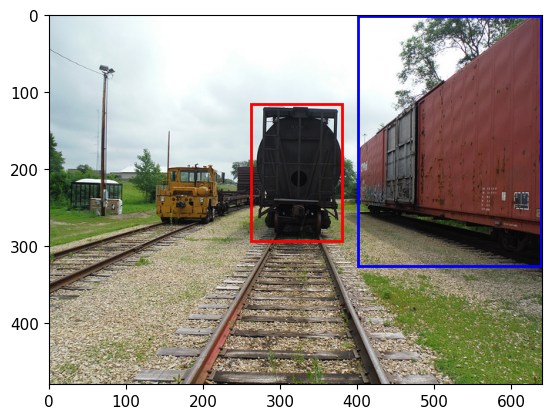

Mean IoU: 0.0000, Recall@0.5 IoU: 0.0000, Mean Cosine Similarity: 0.8296, Mean Euclidean Distance: 6.1367


In [74]:
test_on_one_image(baseline, dataset.get_test(), 455)

Green plant behind a table visible behind a lady's head.


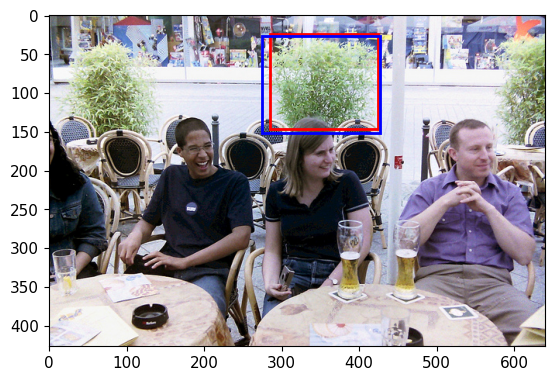

Mean IoU: 0.8662, Recall@0.5 IoU: 1.0000, Mean Cosine Similarity: 0.9683, Mean Euclidean Distance: 2.8730


In [77]:
test_on_one_image(stanza, dataset.get_validation(), 1)

In [43]:
stable_model = VisualGrounding_stable_diffusion('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


Back of a black train car meant to carry liquid sitting still on the train tracks.


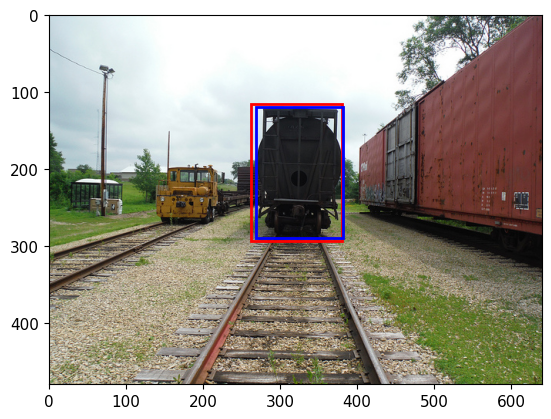

Mean IoU: 0.8992, Recall@0.5 IoU: 1.0000, Mean Cosine Similarity: 0.9702, Mean Euclidean Distance: 2.6621


In [31]:
test_on_one_image(stable_model, dataset.get_test(), 455)

In [44]:
validate(stable_model, dataset.get_validation())

100%|██████████| 4896/4896 [24:40<00:00,  3.31it/s]

Mean IoU: 0.4364, Recall@0.5 IoU: 0.4346, Mean Cosine Similarity: 0.8570, Mean Euclidean Distance: 5.1907


In [29]:
mixed = VisualGrounding_mixed('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder']


a silver cell phone


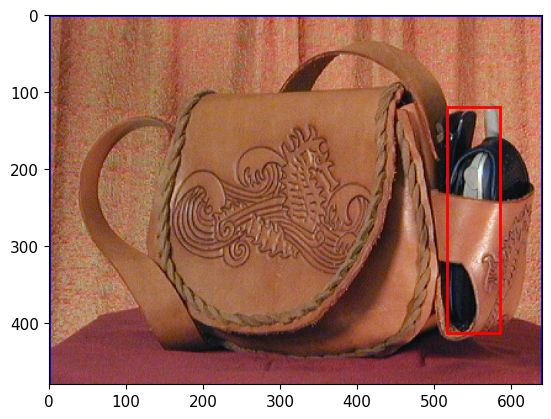

Mean IoU: 0.0649, Recall@0.5 IoU: 0.0000, Mean Cosine Similarity: 0.6909, Mean Euclidean Distance: 8.7891


In [30]:
test_on_one_image(mixed, dataset.get_test(), 3832)

In [ ]:
validate(mixed, dataset.get_validation())

## New

In [32]:
optim = VisualGrounding_ttt_optimized('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [33]:
validate(optim, dataset.get_validation())

100%|██████████| 4896/4896 [24:28<00:00,  3.33it/s]

Mean IoU: 0.4045, Recall@0.5 IoU: 0.3942, Mean Cosine Similarity: 0.8437, Mean Euclidean Distance: 5.4119


In [40]:
mixed = VisualGrounding_mixed_optim('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [41]:
validate(mixed, dataset.get_validation())

100%|██████████| 4896/4896 [29:38<00:00,  2.75it/s]

Mean IoU: 0.4443, Recall@0.5 IoU: 0.4436, Mean Cosine Similarity: 0.8593, Mean Euclidean Distance: 5.1316


In [36]:
final = VisualGrounding_base_mixed_optim('yolov5x', 'ViT-B/32', local_path, local_annotations)

Using cache found in /home/pappol/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-25 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 7949MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [37]:
validate(final, dataset.get_validation())

100%|██████████| 4896/4896 [33:10<00:00,  2.46it/s]

Mean IoU: 0.4907, Recall@0.5 IoU: 0.4957, Mean Cosine Similarity: 0.8728, Mean Euclidean Distance: 4.8257


Woman in black dress with scarf


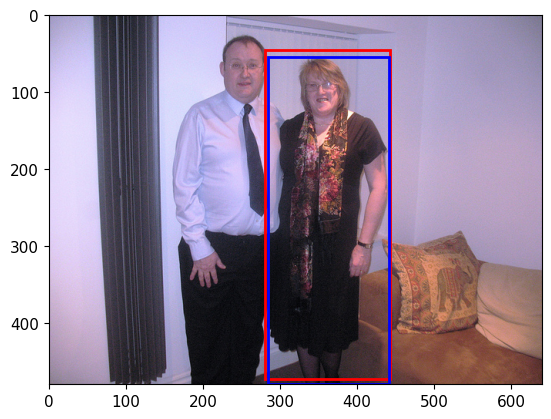

Mean IoU: 0.9354, Recall@0.5 IoU: 1.0000, Mean Cosine Similarity: 0.9873, Mean Euclidean Distance: 1.7861


In [67]:
test_on_one_image(final, dataset.get_validation(), 555)